# Generacion de un dataset histologico falso

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.io import imread
import json
import time
from tqdm import tqdm

In [2]:
with open('configuration.json') as file:
    configuration = json.load(file)

SAVE_PATH = f"{configuration["path"]["data_f"]}/image/"

In [3]:
def backgroud(size):
    loc = random.randint(230, 253)
    return np.ones((size, size, 3)).astype(np.uint8)*loc

def circle(img, center = (255, 255), color = (0, 0, 0), radius = 25):
    new_radius = int(radius*np.random.normal(1, 0.1))
    new_color= (
        random.randint(color[0]-10, color[0]+10),  # Rojo
        random.randint(color[1]-5,  color[1]+5),    # Verde
        random.randint(color[2]-20, color[2]+20)  # Azul
    )
    cv2.circle(img, center, new_radius, new_color, -1)
    return img

def square(img, center = (255, 255), color = (0, 0, 0), radius = 25):
    new_radius = int(radius*np.random.normal(1, 0.1))
    pt = np.ones(2)*np.sqrt(2)*new_radius
    pt1 = (np.array(center)+pt).astype(np.uint8)
    pt2 = (np.array(center)-pt).astype(np.uint8)
    print(center)
    print(pt)
    print(pt1)
    print(pt2)
    new_color= (
        random.randint(color[0]-10, color[0]+10),  # Rojo
        random.randint(color[1]-5,  color[1]+5),    # Verde
        random.randint(color[2]-20, color[2]+20)  # Azul
    )
    cv2.rectangle(img, pt1, pt2, new_color, -1)
    return img

def initial_points(center, radius):
    puntos = []
    for ang in [0, 90, 180, 270]:  # grados
        rad = np.deg2rad(ang)
        new_radius = radius*np.random.normal(1, 0.25)
        x = int(center[0] + new_radius * np.cos(rad))
        y = int(center[1] + new_radius * np.sin(rad))
        puntos.append([x, y])
    return puntos

def add_points(center, points, noise):
    new_points = []
    n = len(points)
    
    for i in range(n):
        p1 = np.array(points[i])
        p2 = np.array(points[(i + 1) % n])
        
        # Radios desde el centro
        r1 = np.linalg.norm(p1 - center)
        r2 = np.linalg.norm(p2 - center)
        rm = (r1 + r2) / 2 * np.random.normal(1, noise)

        # Ángulo medio
        ang1 = np.arctan2(p1[1] - center[1], p1[0] - center[0])
        ang2 = np.arctan2(p2[1] - center[1], p2[0] - center[0])
        if ang2 < ang1:
            ang2 += 2 * np.pi
        ang_medio = (ang1 + ang2) / 2

        # Nuevo punto intermedio
        x = int(center[0] + rm * np.cos(ang_medio))
        y = int(center[1] + rm * np.sin(ang_medio))

        new_points.append(p1.tolist())
        new_points.append([x, y])
    
    return new_points

def poly(img, center, color, radius, steps=2, noise = 0.1):
    points = initial_points(center, radius)
    
    for i in range(steps):
        points = add_points(np.array(center), points, noise/(4**i))
    
    points_array = np.array(points, dtype=np.int32).reshape((-1, 1, 2))
    cv2.fillPoly(img, [points_array], color=color)

    return img
        

In [4]:
def small_color_change(color):
    new_color = (
        random.randint(color[0]-3, color[0]+3),  # Rojo
        random.randint(color[1]-3, color[1]+3),    # Verde 
        random.randint(color[2]-3, color[2]+3)  # Azul
    )
    return new_color

def color_change(color, change = (-20, -10, -30, -20, -10, -5)):
    new_color = (
        random.randint(color[0]+change[0], color[0]+change[1]),  # Rojo
        random.randint(color[1]+change[2], color[1]+change[3]),    # Verde 
        random.randint(color[2]+change[4], color[2]+change[5])  # Azul
    )
    return new_color

def blur(img):

    kernel = np.ones((7, 7), np.float32) / 49
    filtered = np.zeros_like(img)
    for c in range(3):  # R, G, B
        filtered[:, :, c] = cv2.filter2D(img[:, :, c], -1, kernel)    

    return filtered

def histo():
    size = 2048
    radius = random.randint(4, 20)

    img = backgroud(size)
    centers = []

    color = (
        random.randint(180, 255),
        random.randint(120, 170), 
        random.randint(195, 205)
    )

    for _ in range(random.randint(int(4000/radius), int(8000/radius))):
        center = (
            random.randint(0, size),
            random.randint(0, size)
        )
        new_color = small_color_change(color)
        img = poly(img, center, new_color, radius*16, steps = 5)
        centers.append(center)   

    color = color_change(color)

    for i in range(len(centers)):
        new_color = small_color_change(color)
        img = poly(img, centers[i], new_color, radius*6, steps = 5)

    color = color_change(color)

    for i in range(len(centers)):
        new_color = small_color_change(color)
        img = poly(img, centers[i], new_color, radius*3, steps = 5)

    for i in range(50):
        img = blur(img)

    color = (
        random.randint(80, 120),  # Rojo
        random.randint(0, 30),    # Verde 
        random.randint(100, 150)  # Azul
    )

    for i in range(len(centers)):
        new_color = small_color_change(color)
        img = poly(img, centers[i], new_color, radius, steps = 5)

    # Suavizar para dar apariencia más natural
    for i in range(1):
        img = blur(img)

    img = img[256:768, 256:768]

    return img

def to_grey(img):

    aux = np.mean(img, axis=2).astype(np.uint8)
    grey = np.zeros((aux.shape[0], aux.shape[1], 3)).astype(np.uint8)
    grey[:, :, 0] = aux
    grey[:, :, 1] = aux
    grey[:, :, 2] = aux

    aux = grey.copy()

    grey[aux<150] = random.randint(8, 12)
    #grey[aux>=150] = random.randint(80, 120)
    #grey[aux>=155] = random.randint(230, 250)
    
    for i in range(5):
        grey = blur(grey)

    grey[aux>=150] = random.randint(230, 250)

    grey = 255-grey

    for i in range(5):
        grey = blur(grey)

    return grey


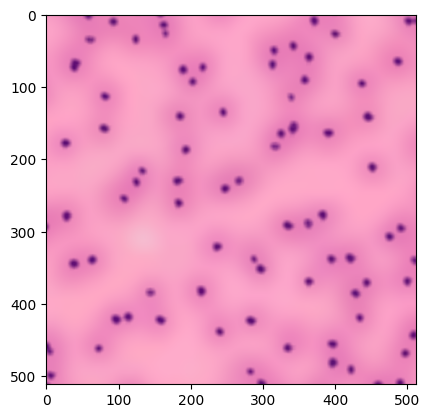

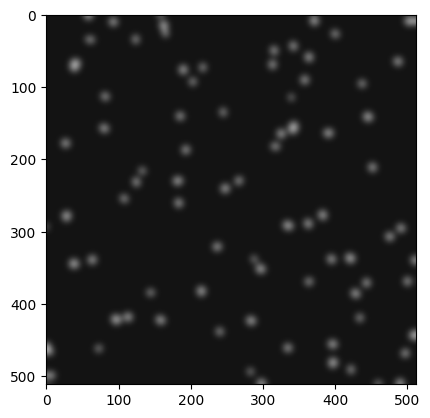

In [5]:
algo = histo()
algo2 = to_grey(algo)

plt.figure()
plt.imshow(algo)

plt.figure()
plt.imshow(algo2)

In [6]:
def save(img, n, r1, r2, r3, path, w = 256, h = 256):
    cv2.imwrite(path+f"{n}.png", img[:256, :256])
    cv2.imwrite(path+f"{n+1}.png", cv2.warpAffine(img[:256, :256], r1, (w, h)))
    cv2.imwrite(path+f"{n+2}.png", cv2.warpAffine(img[:256, :256], r2, (w, h)))
    cv2.imwrite(path+f"{n+3}.png", cv2.warpAffine(img[:256, :256], r3, (w, h)))

def cut_and_save(img, i, r1, r2, r3, path, w = 256, h = 256):
    save(img[:256, :256], i*16, r1, r2, r3, path, w, h)
    save(img[:256, 256:], i*16+4, r1, r2, r3, path, w, h)
    save(img[256:, :256], i*16+8, r1, r2, r3, path, w, h)
    save(img[256:, 256:], i*16+12, r1, r2, r3, path, w, h)

def full_save(img, i, r1, r2, r3, path, w = 256, h = 256):
    cut_and_save(img, i*2, r1, r2, r3, path, w, h)
    cut_and_save(to_grey(img), i*2+1, r1, r2, r3, path, w, h)


In [7]:
length = 1000
w = 256
h = 256
r1 = cv2.getRotationMatrix2D((128, 128), 90, 1)
r2 = cv2.getRotationMatrix2D((128, 128), 180, 1)
r3 = cv2.getRotationMatrix2D((128, 128), 270, 1)
start = time.time()
for i in tqdm(range(1000, 2000)):
    full_save(histo(), i, r1, r2, r3, SAVE_PATH, w, h)

end = time.time()
elapsed = end-start
print(f"Tiempo de ejecución: {int(elapsed // 3600)} horas, {int((elapsed // 60) % 60)} minutos, {int(elapsed % 60)} segundos")

100%|██████████| 1000/1000 [2:05:45<00:00,  7.55s/it] 

Tiempo de ejecución: 2 horas, 5 minutos, 45 segundos


In [8]:
import os

if 0:

    # Ruta a la carpeta con las imágenes
    carpeta = './data_f/image'

    # Extensiones válidas de imágenes
    extensiones_imagen = ('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.webp')

    # Recorre todos los archivos en la carpeta
    for archivo in tqdm(os.listdir(carpeta)):
        ruta_archivo = os.path.join(carpeta, archivo)
        
        # Verifica si es una imagen por su extensión
        if archivo.lower().endswith(extensiones_imagen):
            print(f'Borrando: {ruta_archivo}')
            os.remove(ruta_archivo)

    print("Proceso completado.")